<h1 style="color: #00BFFF;">00 |</h1>

In [1]:
# 📚 Basic libraries
import os # file access
import matplotlib.pyplot as plt #  visualization
import numpy as np # image numeric array manipulation
import shutil # folder operations
import random # shuffle data

# ⚙️ Settings
import warnings # who likes warnings?
warnings.filterwarnings('ignore') # ignore warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # ignoring AVX warning from tensorflow

# 🌐 Computer Vision
import cv2 # image reading
from tensorflow import keras # deep learning and neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.utils import img_to_array, array_to_img, load_img # saving augmented Data
from tensorflow.keras import layers, Model # neural network and model
from keras.models import load_model

In [2]:
# 🎯 Specific Functions
def augment_images(data_dir, datagen, num_images=5):
    for filename in os.listdir(data_dir):
        if filename.endswith(".jpeg"):
            img_path = os.path.join(data_dir, filename)
            img_array = img_to_array(load_img(img_path))  # converting the image to numpy array
            img_array = img_array.reshape((1,) + img_array.shape)  # reshape the data

            # Generate new images
            for i, _ in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=data_dir, save_prefix='aug', save_format='jpeg')):
                if i >= num_images - 1:
                    break
                    
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Downsampling
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    residual_1 = x
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    residual_2 = x  
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Additional convolutional layer
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)  # Increased dropout for bottleneck

    # Upsampling
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.add([x, residual_2])

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.add([x, residual_1])

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    return Model(inputs, outputs)

<h1 style="color: #00BFFF;">01 | Data Extraction</h1>

This public hand dataset contains different folders (numeric) with two subfolders: no_bg and original.

The goal is to segment hands from unseen data with high precision.

In [3]:
data_path = os.path.join(os.path.expanduser("~"), "Documents", "1_projects", "01_hands", "01_data")

<h1 style="color: #00BFFF;">02 | Data Cleaning</h1>

For full Data Cleaning Process documentation, refer to 02_new_prototype python script.

In [4]:
# folders for clean images:
original_clean_path = os.path.join(data_path, '00_original_clean')
no_bg_clean_path = os.path.join(data_path, '00_no_bg_clean')

<h3 style="color: #008080;">Training, Validation and Test</h3>

In [5]:
# original and mask directories for test
test_dir = os.path.join(data_path, "03_test")

# original and mask directories for train and validation
train_dir = os.path.join(data_path, "01_train")
val_dir = os.path.join(data_path, "02_validation")

<h4 style="color: #008080;">Training, Validation and Test split</h3>

For this model, we use (as in 02_new_prototype python script):
* 65% Data for Training (it'll be augmented)
* 25% Data for Validation
* 10% Data for Testing

<h3 style="color: #008080;">Debugging ImageDataGenerator</h3>

ImageDataGenerator wasn't detecting images. They need to be in subfolders.

In [6]:
train_original_dir = os.path.join(train_dir, "original")
train_mask_dir = os.path.join(train_dir, "mask")

val_original_dir = os.path.join(val_dir, "original")
val_mask_dir = os.path.join(val_dir, "mask")

test_original_dir = os.path.join(test_dir, "original")
test_mask_dir = os.path.join(test_dir, "mask")

<h1 style="color: #00BFFF;">03 | Data Pre-Processing</h1>

<h3 style="color: #008080;">Pre-Processing</h3>

In [26]:
train_image_datagen = ImageDataGenerator(rescale=1./255)
train_mask_datagen = ImageDataGenerator(rescale=1./255)

val_image_datagen = ImageDataGenerator(rescale=1./255)
val_mask_datagen = ImageDataGenerator(rescale=1./255)

<h2 style="color: #00BFFF;">Data Augmentation</h3>

For full Data Augmentation process, refer to 02_new_protype python script

<h1 style="color: #00BFFF;">04 | Modeling</h1>

<h3 style="color: #008080;">Fine-Tunning the Model</h3>

In [8]:
# Parameters that we can fine-tune later on
img_height = 480
img_width = 272
image_size = (img_height, img_width)
batch_size = 8

<h3 style="color: #008080;">Train and Validation Data</h3>

In [9]:
train_image_gen = train_image_datagen.flow_from_directory(
    train_original_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

train_mask_gen = train_mask_datagen.flow_from_directory(
    train_mask_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

Found 303 images belonging to 1 classes.
Found 303 images belonging to 1 classes.


In [10]:
X_train = zip(train_image_gen, train_mask_gen)

In [11]:
val_image_gen = val_image_datagen.flow_from_directory(
    val_original_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

val_mask_gen = val_mask_datagen.flow_from_directory(
    val_mask_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

Found 19 images belonging to 1 classes.
Found 19 images belonging to 1 classes.


In [12]:
x_val = zip(val_image_gen, val_mask_gen)

<h3 style="color: #008080;">Model Selection</h3>

In [13]:
model = unet_model(input_shape=(img_height, img_width, 3))

<h3 style="color: #008080;">Hyperparameters</h3>

In [14]:
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.MeanIoU(num_classes=2)]
)

<h3 style="color: #008080;">Epochs</h3>

In [15]:
X_train_steps = len(train_image_gen)
x_val_steps = len(val_image_gen)

epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # my patience for this
    verbose=1,
    restore_best_weights=True 
)

<h3 style="color: #008080;">Check Points</h3>

In [16]:
checkpoints = os.path.join(data_path, "04_epochs", "eva_VIII_{epoch}.keras")

callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoints),
    early_stopping
]

<h3 style="color: #008080;">Deep Learning</h3>

In [17]:
history = model.fit(
    x=X_train,
    epochs=epochs, 
    steps_per_epoch=X_train_steps,
    validation_data=x_val,
    validation_steps=x_val_steps,
    callbacks=callbacks
)

Epoch 1/30
38/38 [==============================] - 783s 20s/step - loss: 0.7063 - accuracy: 0.6075 - mean_io_u: 0.3835 - val_loss: 0.5865 - val_accuracy: 0.7298 - val_mean_io_u: 0.3676
Epoch 2/30
38/38 [==============================] - 732s 19s/step - loss: 0.6225 - accuracy: 0.6946 - mean_io_u: 0.3835 - val_loss: 0.5723 - val_accuracy: 0.7298 - val_mean_io_u: 0.3676
Epoch 3/30
38/38 [==============================] - 727s 19s/step - loss: 0.5847 - accuracy: 0.7174 - mean_io_u: 0.3835 - val_loss: 0.5673 - val_accuracy: 0.7298 - val_mean_io_u: 0.3676
Epoch 4/30
38/38 [==============================] - 722s 19s/step - loss: 0.5642 - accuracy: 0.7300 - mean_io_u: 0.3835 - val_loss: 0.5713 - val_accuracy: 0.7298 - val_mean_io_u: 0.3676
Epoch 5/30
38/38 [==============================] - 720s 19s/step - loss: 0.5535 - accuracy: 0.7364 - mean_io_u: 0.3835 - val_loss: 0.5806 - val_accuracy: 0.7298 - val_mean_io_u: 0.3676
Epoch 6/30
38/38 [==============================] - 719s 19s/step - lo

<h1 style="color: #00BFFF;">05 | Evaluating the Model</h1>

In [83]:
#  path to best epoch
checkpoint_path = os.path.join(data_path, "04_epochs", "eva_VIII_30.keras")

# load the model
loaded_model = load_model(checkpoint_path)

In [84]:
test_image_datagen = ImageDataGenerator(rescale=1./255)
test_mask_datagen = ImageDataGenerator(rescale=1./255)

In [85]:
test_image_gen = test_image_datagen.flow_from_directory(
    test_original_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

test_mask_gen = test_mask_datagen.flow_from_directory(
    test_mask_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

Found 9 images belonging to 1 classes.
Found 9 images belonging to 1 classes.


In [86]:
Y_test = zip(test_image_gen, test_mask_gen)

<h3 style="color: #008080;">Metrics</h3>

# evaluating the model
loss, accuracy, iou = loaded_model.evaluate(Y_test, steps=len(test_image_gen))

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test MeanIoU: {iou:.4f}")

In [87]:
images, masks = next(Y_test)

In [88]:
# predict masks using the model
predictions = loaded_model.predict(images)

1/1 [==============================] - 3s 3s/step


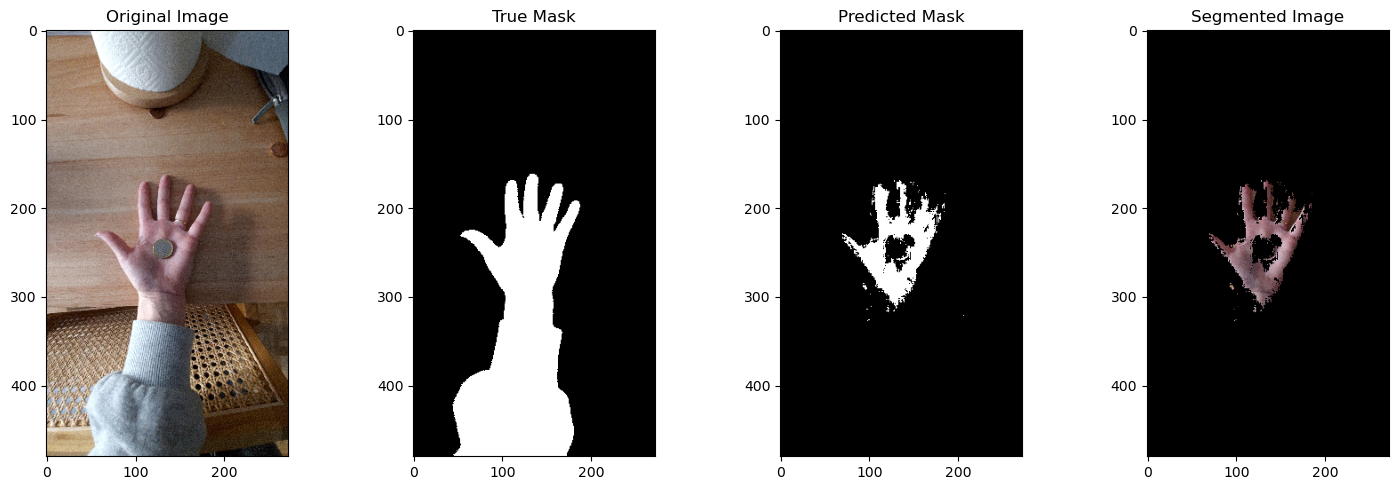

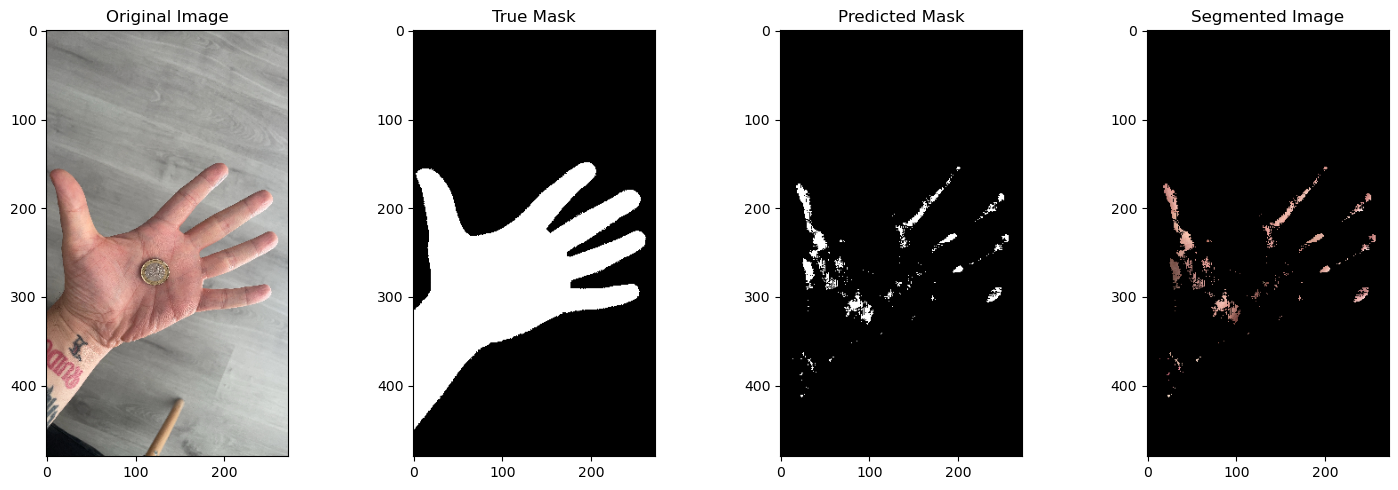

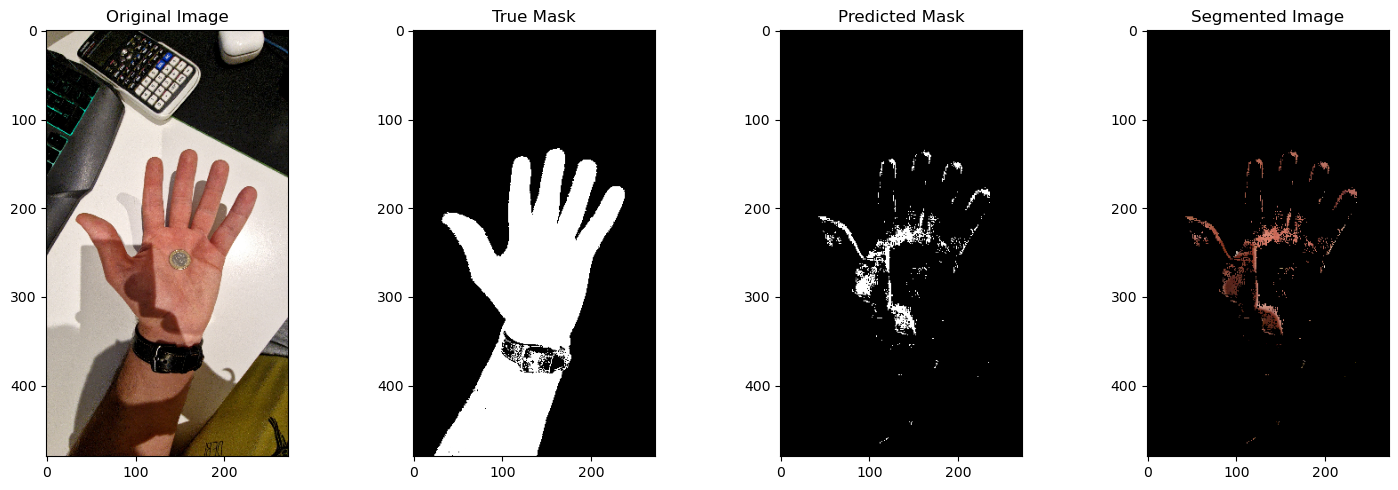

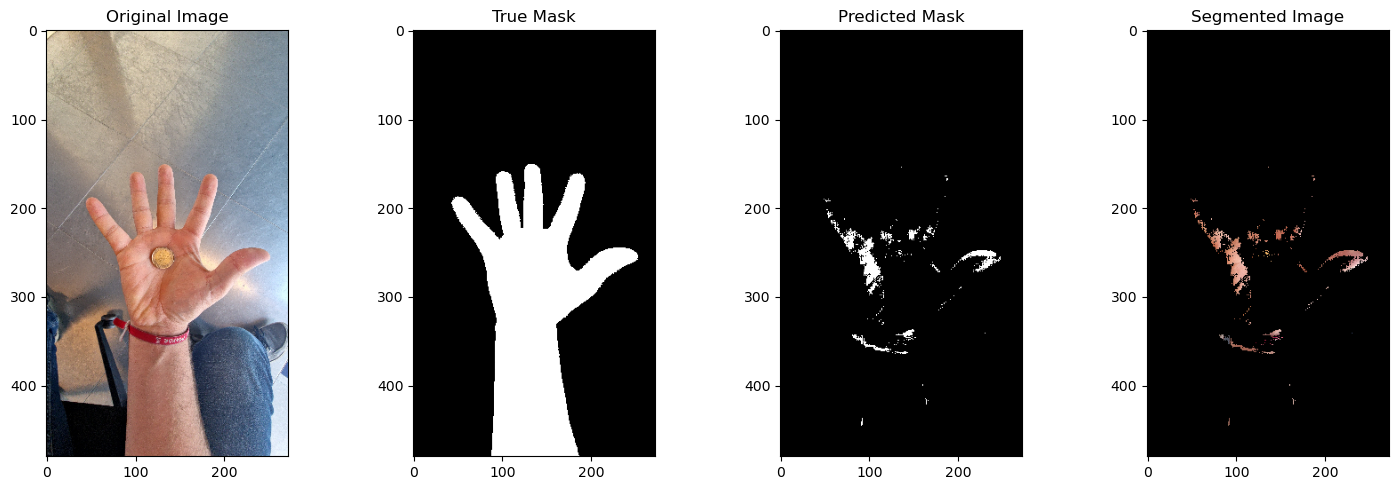

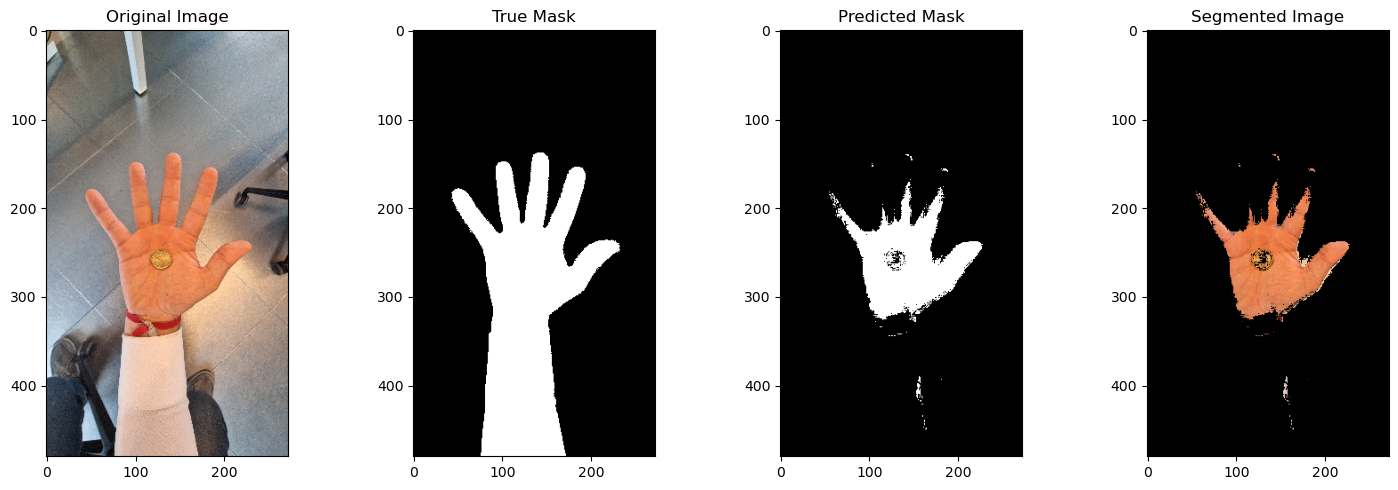

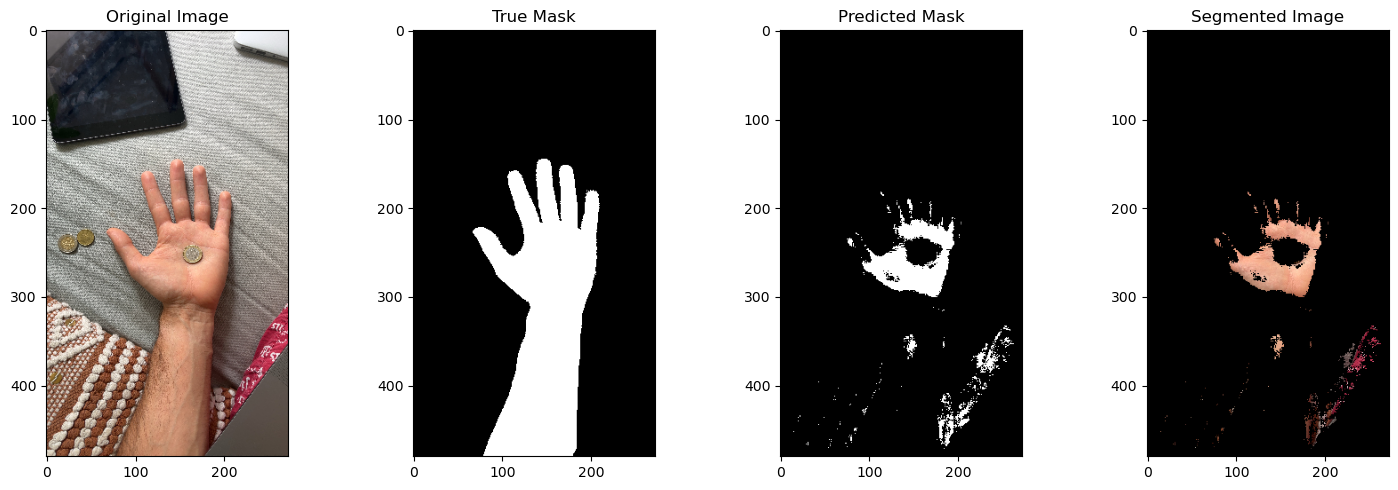

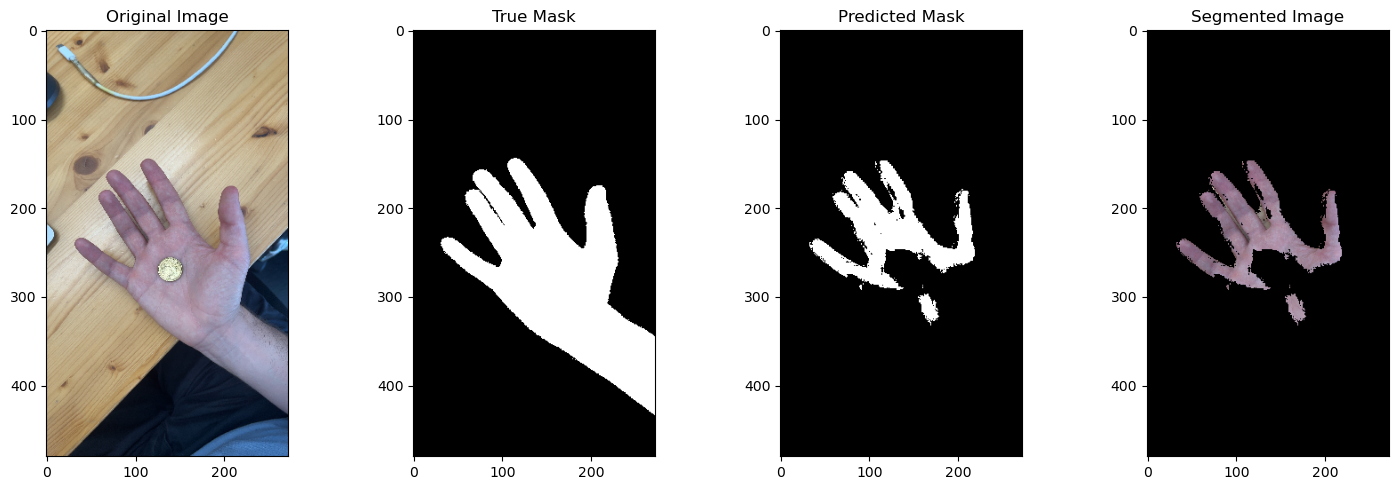

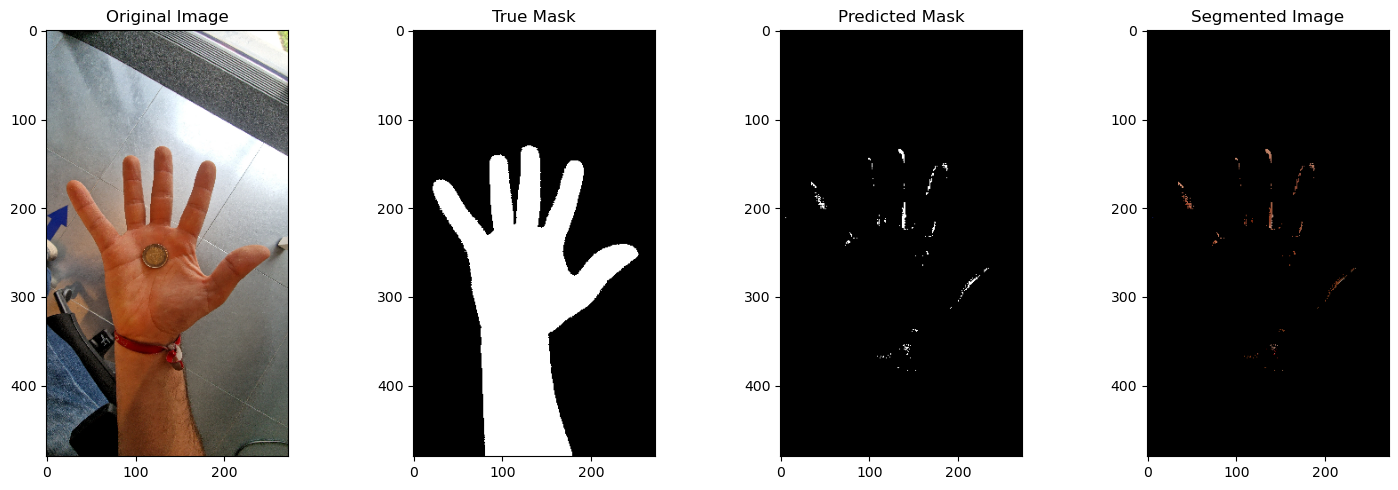

In [89]:
for i in range(len(images)):
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 4, 1)
    plt.imshow(images[i])
    plt.title('Original Image')

    # Display true mask
    plt.subplot(1, 4, 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title('True Mask')

    # Display predicted mask
    plt.subplot(1, 4, 3)
    pred_mask_display = np.where(predictions[i].squeeze() > 0.5, 1, 0)
    plt.imshow(pred_mask_display, cmap='gray')
    plt.title('Predicted Mask')
    
    # Display segmented image
    plt.subplot(1, 4, 4)
    segmented_img = images[i] * pred_mask_display[:, :, np.newaxis]
    plt.imshow(segmented_img)
    plt.title('Segmented Image')
    
    plt.tight_layout()
    plt.show()